In [6]:
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

tsai       : 0.2.15
fastai     : 2.2.5
fastcore   : 1.3.19
torch      : 1.7.1+cu101


# 0. load data

In [7]:
input_fn = 'F:\\Github\\kaggle drought\\data_ndarray.npz'

In [8]:
data = np.load(open(input_fn, 'rb'))

In [9]:
X_train = data['X_train']

In [10]:
X_train.shape

(118024, 90, 18)

In [11]:
print(np.mean(X_train.flatten()))

1.1619668e-07


In [12]:
print(np.std(X_train.flatten()))

1.0000005


In [13]:
X_valid = data['X_valid']

In [14]:
X_test = data['X_test']

In [15]:
y_train = data['y_train']
y_train = np.array([int(i) for i in y_train])

In [16]:
y_valid = data['y_valid']
y_valid = np.array([int(i) for i in y_valid])

In [17]:
y_test = data['y_test']
y_test = np.array([int(i) for i in y_test])

We need to exchange two axes：
* **number of samples**
* **number of features** (aka variables, dimensions, channels)
* **number of steps** (or length, time steps, sequence steps)

In [18]:
X_train = X_train.transpose(0, 2, 1)
X_train.shape

(118024, 18, 90)

In [19]:
X_valid = X_valid.transpose(0, 2, 1)
X_valid.shape

(20721, 18, 90)

In [20]:
X_test = X_test.transpose(0, 2, 1)
X_test.shape

(102430, 18, 90)

We already have the split:

In [21]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [22]:
X.shape

(138745, 18, 90)

In [23]:
y.shape

(138745,)

In [24]:
splits

((#118024) [0,1,2,3,4,5,6,7,8,9...],
 (#20721) [118024,118025,118026,118027,118028,118029,118030,118031,118032,118033...])

In [25]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

(#138745) [(TSTensor(vars:18, len:90), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(1, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(1, dtype=torch.int32))...]

# 1. Model and Hyperparameter Tuning

In [26]:
import hyperopt
print(hyperopt.__version__)

0.2.5


In [27]:
from hyperopt import Trials, STATUS_OK, STATUS_FAIL, tpe, fmin, hp

In [28]:
search_space = {
    'batch_size': hp.choice('bs', [256, 512, 1024]),
    'time_steps': hp.choice('ts', [30, 60, 90]),  # lookback window size
    "lr": hp.choice('lr', [0.1, 0.01, 0.001, 0.0001]),
    "epochs": hp.choice('epochs', [10, 50, 100]),  # we would also use early stopping
    "patience": hp.choice('patience', [5, 10]),  # early stopping patience
    "optimizer": hp.choice('optimizer', [Adam, SGD, RMSProp]),  # https://docs.fast.ai/optimizer
    # model parameters
    "n_layers": hp.choice('n_layers', [1, 2, 3, 4, 5]),
    "hidden_size": hp.choice('hidden_size', [50, 100, 200]),
    "bidirectional": hp.choice('bidirectional', [True, False])
}

In [29]:
search_space

{'batch_size': <hyperopt.pyll.base.Apply at 0x1a5601ce1c8>,
 'time_steps': <hyperopt.pyll.base.Apply at 0x1a5601ce6c8>,
 'lr': <hyperopt.pyll.base.Apply at 0x1a5601cec88>,
 'epochs': <hyperopt.pyll.base.Apply at 0x1a5601cd188>,
 'patience': <hyperopt.pyll.base.Apply at 0x1a5601cd608>,
 'optimizer': <hyperopt.pyll.base.Apply at 0x1a5601cdc08>,
 'n_layers': <hyperopt.pyll.base.Apply at 0x1a5601cb488>,
 'hidden_size': <hyperopt.pyll.base.Apply at 0x1a5601cba08>,
 'bidirectional': <hyperopt.pyll.base.Apply at 0x1a5601cbf88>}

In [30]:
X.shape

(138745, 18, 90)

In [31]:
time_steps = 30

In [32]:
X[:, :, -time_steps:].shape

(138745, 18, 30)

In [33]:
X_test[:, :, -time_steps:].shape

(102430, 18, 30)

In [34]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [35]:
import time
from fastai.callback.tracker import EarlyStoppingCallback

In [36]:
import gc

In [37]:
# clear memory 
gc.collect()

60

In [38]:
def create_model_hypopt(params):
    
    try:
        # clear memory 
        gc.collect()
        print("Trying params:",params)
        batch_size = params["batch_size"]
        time_steps = params["time_steps"]
    
        # Create data loader
        tfms  = [None, [Categorize()]]
        dsets = TSDatasets(X[:, :, -time_steps:], y, tfms=tfms, splits=splits, inplace=True)
        # set num_workers for memory bottleneck
        dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
        # Create model
        arch = GRU
        k = {
            'n_layers': params['n_layers'],
            'hidden_size': params['hidden_size'],
            'bidirectional': params['bidirectional']
        }
        model = create_model(arch, dls=dls, **k)
        print(model.__class__.__name__)
    
        # Training the model
        learn = Learner(dls, model, metrics=accuracy, opt_func=params['optimizer'])
        start = time.time()
        learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                            cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
        learn.plot_metrics()
        elapsed = time.time() - start
    
        vals = learn.recorder.values[-1]
        # vals[0], vals[1], vals[2]
        # train loss, valid loss, accuracy
        val_loss = vals[1]
    
        # delete tmp variables
        del dls
        del model
        del learn
        return {'loss': val_loss, 'status': STATUS_OK} # if accuracy use '-' sign, model is optional
    except:
        return {'loss': None, 'status': STATUS_FAIL}

Search the parameters:

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': True, 'epochs': 100, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function RMSProp at 0x00000243C597C1F8>, 'patience': 10, 'time_steps': 60}
GRU                                                                                                                    
  0%|                                                                           | 0/30 [00:32<?, ?trial/s, best loss=?]

epoch,train_loss,valid_loss,accuracy,time
0,0.977475,0.928779,0.658028,00:02
1,0.932534,0.913029,0.671493,00:02
2,0.911409,0.909018,0.670093,00:02
3,0.904585,0.863681,0.681676,00:02
4,0.897335,0.908624,0.675354,00:02
5,0.885499,0.859605,0.689059,00:02
6,0.872847,0.875337,0.686357,00:02
7,0.860869,0.854643,0.687805,00:02
8,0.849114,0.889888,0.674292,00:02
9,0.837051,0.883142,0.676319,00:02


No improvement since epoch 7: early stopping                                                                           
  0%|                                                                           | 0/30 [01:19<?, ?trial/s, best loss=?]

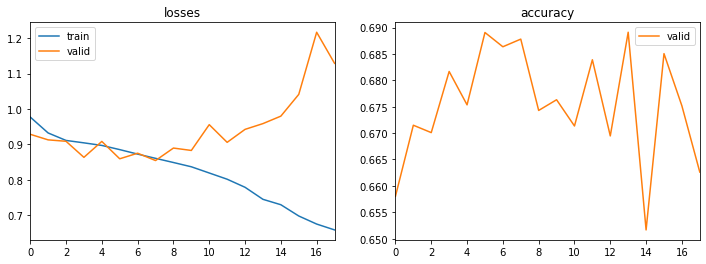

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': False, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x00000243C597C438>, 'patience': 10, 'time_steps': 60}
GRU                                                                                                                    
  3%|█▋                                               | 1/30 [01:46<38:25, 79.51s/trial, best loss: 1.1290135383605957]

epoch,train_loss,valid_loss,accuracy,time
0,1.003366,0.937215,0.658897,00:02
1,0.923581,0.902635,0.667246,00:01
2,0.902908,0.888576,0.669514,00:02
3,0.887531,0.896157,0.668211,00:02
4,0.881344,0.907538,0.669707,00:01
5,0.855778,0.858375,0.683703,00:01
6,0.830393,0.834657,0.691135,00:02
7,0.802715,0.941452,0.668790,00:02
8,0.782113,0.867022,0.687081,00:02
9,0.746278,0.971476,0.665798,00:01


No improvement since epoch 6: early stopping                                                                           
  3%|█▋                                               | 1/30 [02:20<38:25, 79.51s/trial, best loss: 1.1290135383605957]

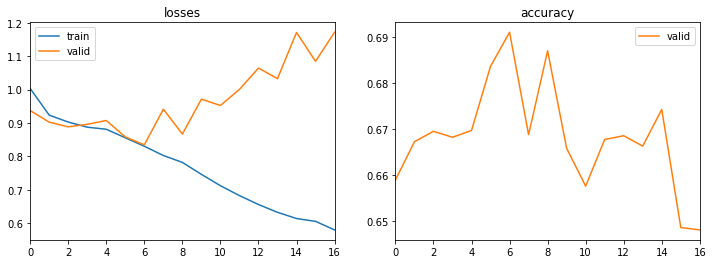

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': False, 'epochs': 10, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 4, 'optimizer': <function SGD at 0x00000243C597C0D8>, 'patience': 10, 'time_steps': 60}
GRU                                                                                                                    
  7%|███▎                                             | 2/30 [02:47<34:30, 73.96s/trial, best loss: 1.1290135383605957]

epoch,train_loss,valid_loss,accuracy,time
0,1.817616,1.817140,0.042807,00:11
1,1.813202,1.810376,0.043338,00:11
2,1.804624,1.800340,0.043675,00:11
3,1.795152,1.790686,0.047488,00:11
4,1.786412,1.782332,0.063462,00:11
5,1.779448,1.775810,0.128951,00:11
6,1.774169,1.771358,0.220163,00:11
7,1.770972,1.768861,0.285025,00:11
8,1.769293,1.767885,0.313595,00:11
9,1.768965,1.767743,0.316973,00:11


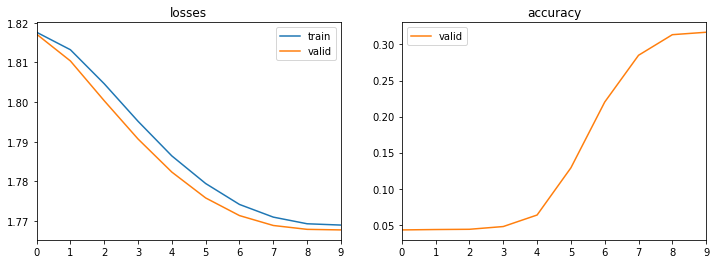

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': True, 'epochs': 100, 'hidden_size': 50, 'lr': 0.0001, 'n_layers': 1, 'optimizer': <function SGD at 0x00000243C597C0D8>, 'patience': 10, 'time_steps': 30}
GRU                                                                                                                    
 10%|████▉                                            | 3/30 [05:09<42:32, 94.55s/trial, best loss: 1.1290135383605957]

epoch,train_loss,valid_loss,accuracy,time
0,1.872682,1.869745,0.041552,00:01
1,1.872337,1.869423,0.041600,00:01
2,1.871645,1.869002,0.041600,00:01
3,1.871240,1.868435,0.041552,00:01
4,1.870793,1.867677,0.041600,00:01
5,1.869469,1.866687,0.041697,00:01
6,1.868530,1.865426,0.041842,00:01
7,1.866979,1.863862,0.041842,00:01
8,1.865236,1.861967,0.042179,00:01
9,1.863433,1.859719,0.042566,00:01


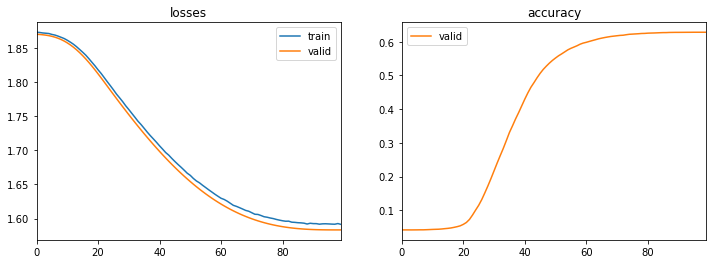

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 5, 'optimizer': <function RMSProp at 0x00000243C597C1F8>, 'patience': 10, 'time_steps': 60}
GRU                                                                                                                    
 13%|██████▍                                         | 4/30 [07:30<47:07, 108.74s/trial, best loss: 1.1290135383605957]

epoch,train_loss,valid_loss,accuracy,time
0,1.694889,1.648171,0.664543,00:14
1,1.532603,1.425679,0.664543,00:14
2,1.253888,1.138476,0.664543,00:15
3,1.119146,1.089881,0.663192,00:15
4,1.072036,1.054164,0.656629,00:15
5,1.042160,1.002363,0.654988,00:15
6,1.009054,0.956474,0.654891,00:15
7,0.973540,0.933107,0.651947,00:15
8,0.958178,0.927719,0.654795,00:15
9,0.947018,0.924178,0.656146,00:15


No improvement since epoch 21: early stopping                                                                          
 13%|██████▍                                         | 4/30 [15:36<47:07, 108.74s/trial, best loss: 1.1290135383605957]

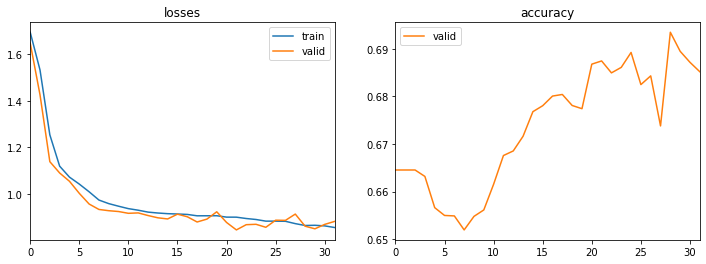

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': True, 'epochs': 10, 'hidden_size': 100, 'lr': 0.0001, 'n_layers': 4, 'optimizer': <function Adam at 0x00000243C597C438>, 'patience': 5, 'time_steps': 90}
GRU                                                                                                                    
 17%|███████▋                                      | 5/30 [16:02<1:35:43, 229.73s/trial, best loss: 0.8816114664077759]

epoch,train_loss,valid_loss,accuracy,time
0,1.720768,1.607697,0.664447,00:15
1,1.187360,1.059892,0.650210,00:15
2,1.012771,0.945331,0.656484,00:15
3,0.929972,0.883981,0.670576,00:15
4,0.900364,0.866027,0.675884,00:15
5,0.884563,0.862692,0.680807,00:15
6,0.876553,0.839662,0.682496,00:15
7,0.871320,0.852055,0.679986,00:15
8,0.872404,0.850142,0.681434,00:15
9,0.871195,0.850363,0.680952,00:15


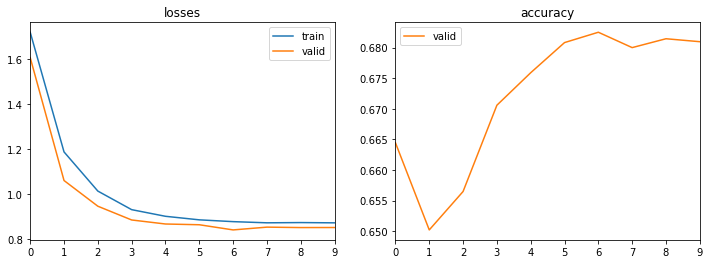

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 5, 'optimizer': <function Adam at 0x00000243C597C438>, 'patience': 10, 'time_steps': 90}
GRU                                                                                                                    
 20%|█████████▏                                    | 6/30 [19:05<1:26:17, 215.74s/trial, best loss: 0.8503633737564087]

epoch,train_loss,valid_loss,accuracy,time
0,1.009389,0.977450,0.658076,00:28
1,0.904031,0.886385,0.670914,00:29
2,0.885947,0.866858,0.686453,00:29
3,0.863348,0.864593,0.685392,00:29
4,0.847775,0.838776,0.687177,00:29
5,0.848395,0.846586,0.691038,00:29
6,0.826804,0.855640,0.688915,00:29
7,0.805870,0.812168,0.698615,00:30
8,0.768365,0.842783,0.691810,00:29
9,0.739713,0.818611,0.699677,00:29


No improvement since epoch 7: early stopping                                                                           
 20%|█████████▏                                    | 6/30 [27:54<1:26:17, 215.74s/trial, best loss: 0.8503633737564087]

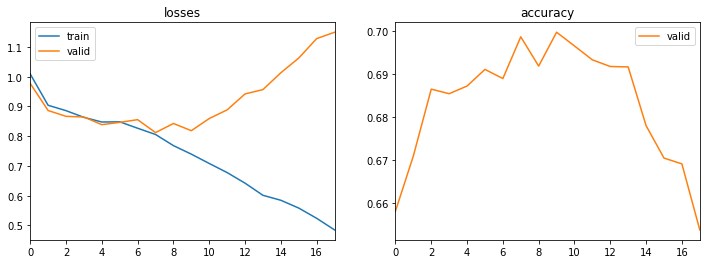

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': True, 'epochs': 50, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 5, 'optimizer': <function RMSProp at 0x00000243C597C1F8>, 'patience': 5, 'time_steps': 90}
GRU                                                                                                                    
 23%|██████████▋                                   | 7/30 [28:20<2:01:42, 317.48s/trial, best loss: 0.8503633737564087]

epoch,train_loss,valid_loss,accuracy,time
0,0.933489,0.894314,0.655760,00:28
1,0.892479,1.059505,0.673471,00:29
2,0.958230,0.930898,0.671010,00:28
3,1.071183,1.041076,0.663192,00:28
4,1.152108,1.124873,0.664543,00:29
5,1.139953,1.137285,0.664543,00:29


No improvement since epoch 0: early stopping                                                                           
 23%|██████████▋                                   | 7/30 [31:14<2:01:42, 317.48s/trial, best loss: 0.8503633737564087]

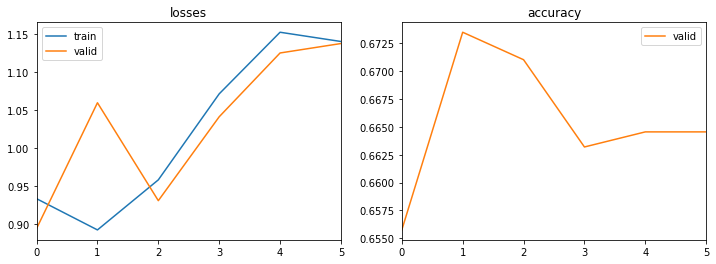

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': False, 'epochs': 100, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 2, 'optimizer': <function SGD at 0x00000243C597C0D8>, 'patience': 5, 'time_steps': 30}
GRU                                                                                                                    
 27%|████████████▎                                 | 8/30 [31:44<1:43:30, 282.30s/trial, best loss: 0.8503633737564087]

epoch,train_loss,valid_loss,accuracy,time
0,1.608571,1.503495,0.664543,00:01
1,1.361580,1.249676,0.664543,00:01
2,1.197933,1.136894,0.664543,00:01
3,1.131754,1.107340,0.664591,00:01
4,1.096905,1.093820,0.662420,00:01
5,1.083306,1.085557,0.656677,00:01
6,1.068788,1.077953,0.651899,00:01
7,1.060160,1.069684,0.649776,00:01
8,1.055788,1.060358,0.647749,00:01
9,1.046682,1.052159,0.646542,00:01


No improvement since epoch 39: early stopping                                                                          
 27%|████████████▎                                 | 8/30 [32:53<1:43:30, 282.30s/trial, best loss: 0.8503633737564087]

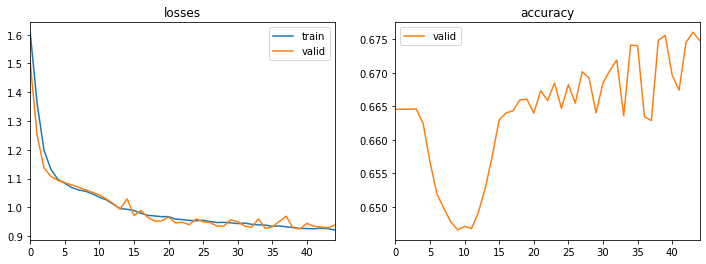

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': False, 'epochs': 50, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 5, 'optimizer': <function RMSProp at 0x00000243C597C1F8>, 'patience': 5, 'time_steps': 60}
GRU                                                                                                                    
 30%|█████████████▊                                | 9/30 [33:21<1:19:32, 227.24s/trial, best loss: 0.8503633737564087]

epoch,train_loss,valid_loss,accuracy,time
0,0.940559,0.938243,0.670383,00:06
1,0.919790,0.951900,0.654023,00:06
2,0.909546,0.916226,0.666667,00:06
3,0.892489,0.948293,0.652526,00:06
4,0.877936,1.004818,0.675884,00:06
5,0.813038,0.986031,0.662227,00:06
6,0.767550,0.945458,0.658318,00:06
7,0.733931,1.092407,0.666184,00:06


No improvement since epoch 2: early stopping                                                                           
 30%|█████████████▊                                | 9/30 [34:10<1:19:32, 227.24s/trial, best loss: 0.8503633737564087]

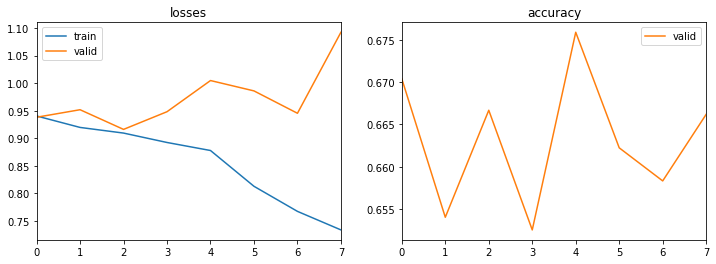

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.1, 'n_layers': 5, 'optimizer': <function SGD at 0x00000243C597C0D8>, 'patience': 5, 'time_steps': 60}
GRU                                                                                                                    
 33%|███████████████                              | 10/30 [34:39<1:00:40, 182.05s/trial, best loss: 0.8503633737564087]

epoch,train_loss,valid_loss,accuracy,time
0,1.129066,1.108824,0.664543,00:42
1,1.083612,1.090649,0.662178,00:43
2,1.055213,1.063664,0.652961,00:43
3,1.047014,1.036412,0.647893,00:44
4,1.026827,1.024267,0.646687,00:44
5,1.009164,1.009379,0.645577,00:45
6,0.991363,0.995172,0.652719,00:45
7,0.976877,0.982025,0.663481,00:45
8,0.956006,0.946653,0.666184,00:45
9,0.961489,0.939592,0.665364,00:46


No improvement since epoch 29: early stopping                                                                          
 33%|██████████████▎                            | 10/30 [1:01:56<1:00:40, 182.05s/trial, best loss: 0.8503633737564087]

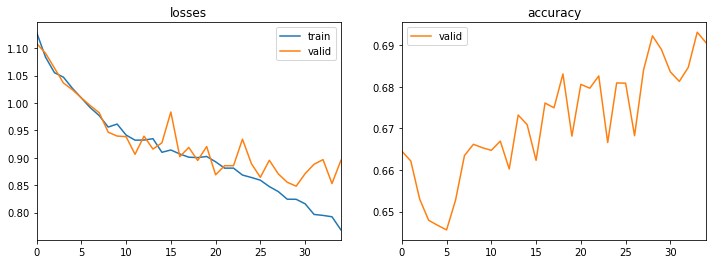

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x00000243C597C438>, 'patience': 5, 'time_steps': 30}
GRU                                                                                                                    
 37%|███████████████▊                           | 11/30 [1:02:26<3:18:41, 627.43s/trial, best loss: 0.8503633737564087]

epoch,train_loss,valid_loss,accuracy,time
0,1.620625,1.590458,0.581632,00:02
1,1.203952,1.148417,0.631147,00:02
2,1.038401,1.018095,0.651272,00:02
3,0.988137,0.970552,0.651996,00:02
4,0.954161,0.951672,0.657015,00:02
5,0.946415,0.939164,0.663771,00:02
6,0.937948,0.931297,0.665846,00:02
7,0.936400,0.923472,0.664881,00:02
8,0.924381,0.930990,0.663723,00:02
9,0.922721,0.934935,0.667004,00:02


No improvement since epoch 15: early stopping                                                                          
 37%|███████████████▊                           | 11/30 [1:03:12<3:18:41, 627.43s/trial, best loss: 0.8503633737564087]

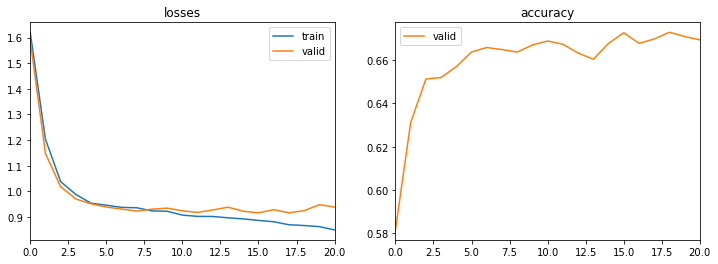

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': False, 'epochs': 10, 'hidden_size': 100, 'lr': 0.0001, 'n_layers': 3, 'optimizer': <function RMSProp at 0x00000243C597C1F8>, 'patience': 5, 'time_steps': 60}
GRU                                                                                                                    
 40%|█████████████████▏                         | 12/30 [1:03:41<2:18:31, 461.77s/trial, best loss: 0.8503633737564087]

epoch,train_loss,valid_loss,accuracy,time
0,1.677412,1.570191,0.664495,00:03
1,1.170557,1.036852,0.655422,00:03
2,1.015439,0.957336,0.654216,00:03
3,0.958187,0.931901,0.655181,00:03
4,0.938663,0.912771,0.658800,00:03
5,0.927130,0.913824,0.661165,00:03
6,0.922884,0.910639,0.662758,00:03
7,0.916182,0.904272,0.663771,00:03
8,0.915396,0.905585,0.665026,00:03
9,0.915886,0.904905,0.664978,00:03


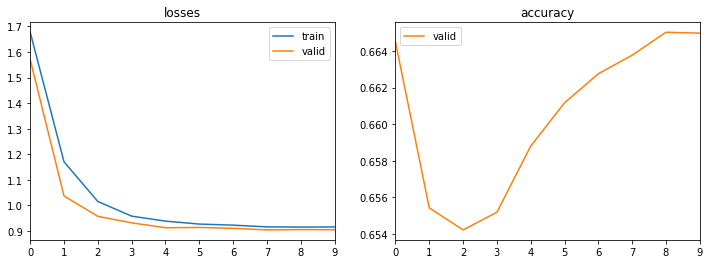

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.0001, 'n_layers': 3, 'optimizer': <function RMSProp at 0x00000243C597C1F8>, 'patience': 5, 'time_steps': 90}
GRU                                                                                                                    
 43%|██████████████████▋                        | 13/30 [1:04:48<1:37:15, 343.27s/trial, best loss: 0.8503633737564087]

epoch,train_loss,valid_loss,accuracy,time
0,1.805815,1.790949,0.031514,00:05
1,1.761306,1.735488,0.284832,00:04
2,1.677225,1.624202,0.621736,00:04
3,1.496506,1.390906,0.663047,00:04
4,1.246484,1.162478,0.664447,00:04
5,1.130036,1.098270,0.662372,00:05
6,1.078793,1.054796,0.655036,00:05
7,1.037941,1.000853,0.657304,00:05
8,0.996980,0.953505,0.657015,00:05
9,0.947313,0.909842,0.664398,00:05


No improvement since epoch 23: early stopping                                                                          
 43%|██████████████████▋                        | 13/30 [1:07:16<1:37:15, 343.27s/trial, best loss: 0.8503633737564087]

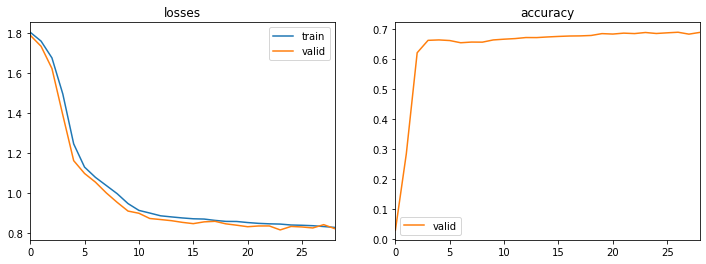

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': False, 'epochs': 50, 'hidden_size': 50, 'lr': 0.1, 'n_layers': 3, 'optimizer': <function Adam at 0x00000243C597C438>, 'patience': 10, 'time_steps': 30}
GRU                                                                                                                    
 47%|████████████████████                       | 14/30 [1:07:45<1:18:17, 293.58s/trial, best loss: 0.8221107721328735]

epoch,train_loss,valid_loss,accuracy,time
0,0.926707,0.913056,0.677863,00:04
1,0.865019,1.037070,0.646590,00:04
2,0.849614,1.053275,0.654988,00:04
3,0.911732,1.000120,0.667101,00:04
4,0.997312,0.968543,0.662999,00:04
5,1.039573,1.055870,0.655856,00:04
6,1.048997,1.109518,0.661020,00:04
7,1.052100,1.095812,0.660875,00:04
8,1.060730,1.104116,0.664350,00:04
9,1.080025,1.103802,0.664447,00:04


No improvement since epoch 0: early stopping                                                                           
 47%|████████████████████                       | 14/30 [1:08:37<1:18:17, 293.58s/trial, best loss: 0.8221107721328735]

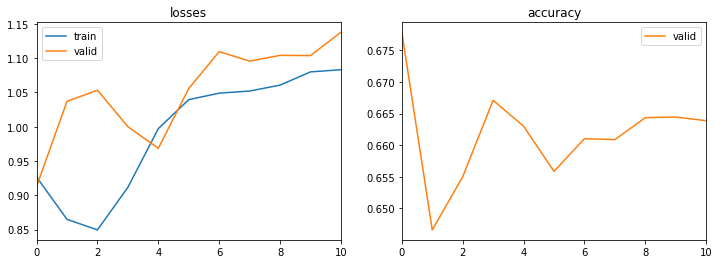

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': True, 'epochs': 100, 'hidden_size': 50, 'lr': 0.001, 'n_layers': 5, 'optimizer': <function RMSProp at 0x00000243C597C1F8>, 'patience': 10, 'time_steps': 30}
GRU                                                                                                                    
 50%|██████████████████████▌                      | 15/30 [1:09:04<57:26, 229.78s/trial, best loss: 0.8221107721328735]

epoch,train_loss,valid_loss,accuracy,time
0,1.089682,1.071460,0.655132,00:05
1,1.025028,0.986655,0.655181,00:05
2,0.974016,0.952566,0.659138,00:05
3,0.960607,0.937683,0.666522,00:05
4,0.950289,0.933530,0.668259,00:05
5,0.944691,0.916156,0.670865,00:05
6,0.940262,0.926902,0.671493,00:05
7,0.939458,0.921882,0.672024,00:05
8,0.939288,1.019875,0.664640,00:05
9,0.930644,0.911597,0.679456,00:05


No improvement since epoch 9: early stopping                                                                           
 50%|██████████████████████▌                      | 15/30 [1:10:51<57:26, 229.78s/trial, best loss: 0.8221107721328735]

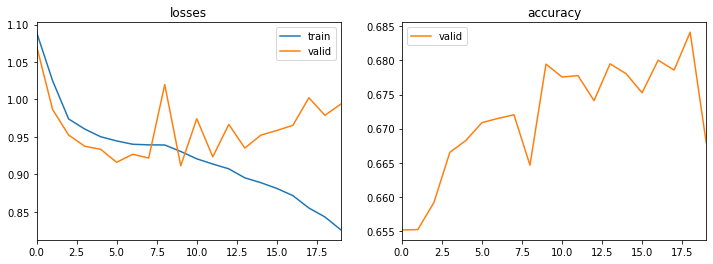

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': True, 'epochs': 100, 'hidden_size': 50, 'lr': 0.0001, 'n_layers': 3, 'optimizer': <function Adam at 0x00000243C597C438>, 'patience': 10, 'time_steps': 30}
GRU                                                                                                                    
 53%|████████████████████████                     | 16/30 [1:11:17<46:52, 200.90s/trial, best loss: 0.8221107721328735]

epoch,train_loss,valid_loss,accuracy,time
0,1.741960,1.732555,0.585445,00:02
1,1.715012,1.700641,0.650644,00:02
2,1.677607,1.657610,0.662082,00:02
3,1.624854,1.595832,0.664543,00:02
4,1.547747,1.505192,0.664543,00:02
5,1.435965,1.375578,0.664543,00:02
6,1.292103,1.224680,0.664543,00:02
7,1.172104,1.131731,0.664688,00:02
8,1.114460,1.094852,0.660538,00:02
9,1.081510,1.066149,0.656629,00:02


No improvement since epoch 44: early stopping                                                                          
 53%|████████████████████████                     | 16/30 [1:13:29<46:52, 200.90s/trial, best loss: 0.8221107721328735]

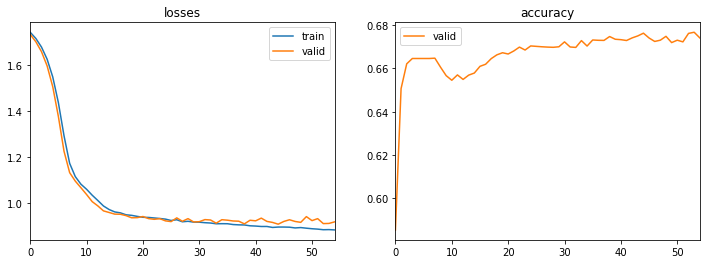

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 2, 'optimizer': <function SGD at 0x00000243C597C0D8>, 'patience': 10, 'time_steps': 60}
GRU                                                                                                                    
 57%|█████████████████████████▌                   | 17/30 [1:13:59<40:46, 188.17s/trial, best loss: 0.8221107721328735]

epoch,train_loss,valid_loss,accuracy,time
0,1.827756,1.829803,0.066116,00:13
1,1.824089,1.825343,0.066406,00:13
2,1.819013,1.819545,0.067130,00:13
3,1.812266,1.811787,0.067902,00:13
4,1.803310,1.801504,0.070894,00:13
5,1.791536,1.788206,0.105738,00:13
6,1.776626,1.771499,0.231553,00:14
7,1.758428,1.751081,0.425896,00:14
8,1.736206,1.726762,0.616862,00:14
9,1.710109,1.698458,0.658607,00:14


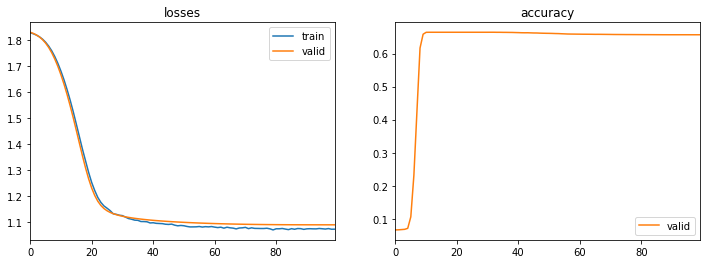

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': True, 'epochs': 10, 'hidden_size': 200, 'lr': 0.1, 'n_layers': 1, 'optimizer': <function RMSProp at 0x00000243C597C1F8>, 'patience': 5, 'time_steps': 90}
GRU                                                                                                                    
 60%|█████████████████████████▊                 | 18/30 [1:38:46<1:55:48, 579.02s/trial, best loss: 0.8221107721328735]

epoch,train_loss,valid_loss,accuracy,time
0,1.551148,1.082240,0.618117,00:06
1,4.763547,5.856024,0.338015,00:06
2,4.820130,2.621846,0.520631,00:07
3,4.176042,5.821884,0.541962,00:07
4,3.374362,3.055230,0.330486,00:07
5,2.599416,2.447836,0.512137,00:07


No improvement since epoch 0: early stopping                                                                           
 60%|█████████████████████████▊                 | 18/30 [1:39:29<1:55:48, 579.02s/trial, best loss: 0.8221107721328735]

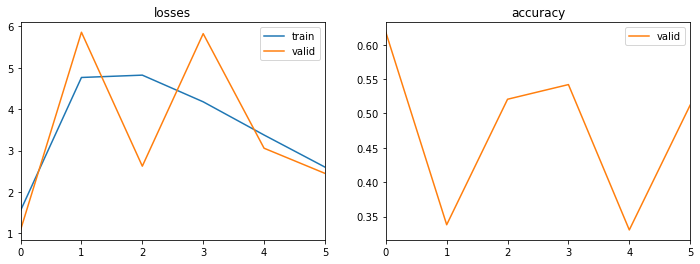

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': False, 'epochs': 50, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function SGD at 0x00000243C597C0D8>, 'patience': 5, 'time_steps': 60}
GRU                                                                                                                    
 63%|███████████████████████████▏               | 19/30 [1:39:54<1:18:05, 425.99s/trial, best loss: 0.8221107721328735]

epoch,train_loss,valid_loss,accuracy,time
0,1.650896,1.625045,0.664543,00:06
1,1.468424,1.428611,0.664543,00:06
2,1.234816,1.196825,0.664543,00:06
3,1.119375,1.113874,0.664543,00:07
4,1.090733,1.094391,0.664350,00:07
5,1.063662,1.081407,0.659814,00:07
6,1.061049,1.073013,0.654746,00:07
7,1.060929,1.063650,0.651272,00:07
8,1.039760,1.055280,0.649245,00:07
9,1.038123,1.046228,0.648617,00:07


No improvement since epoch 31: early stopping                                                                          
 63%|███████████████████████████▏               | 19/30 [1:44:25<1:18:05, 425.99s/trial, best loss: 0.8221107721328735]

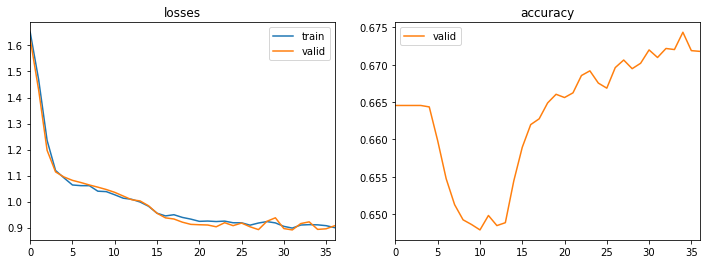

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': True, 'epochs': 10, 'hidden_size': 100, 'lr': 0.0001, 'n_layers': 4, 'optimizer': <function Adam at 0x00000243C597C438>, 'patience': 5, 'time_steps': 90}
GRU                                                                                                                    
 67%|████████████████████████████▋              | 20/30 [1:44:54<1:04:30, 387.03s/trial, best loss: 0.8221107721328735]

epoch,train_loss,valid_loss,accuracy,time
0,1.719056,1.600552,0.654071,00:15
1,1.180717,1.045967,0.655422,00:16
2,1.013703,0.933151,0.655712,00:16
3,0.930324,0.899130,0.669900,00:16
4,0.898319,0.887629,0.677622,00:17
5,0.886629,0.864912,0.681965,00:17
6,0.880548,0.869073,0.678683,00:17
7,0.875114,0.859901,0.683172,00:17
8,0.872364,0.853540,0.683606,00:17
9,0.871047,0.852775,0.684233,00:17


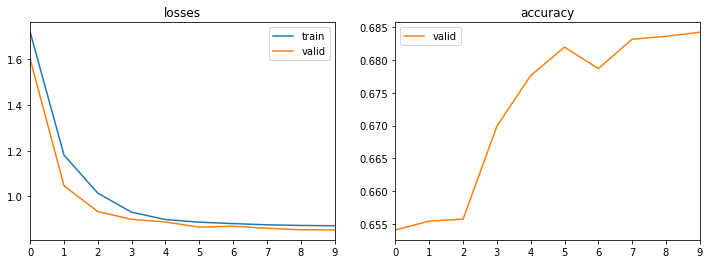

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': True, 'epochs': 10, 'hidden_size': 50, 'lr': 0.0001, 'n_layers': 4, 'optimizer': <function Adam at 0x00000243C597C438>, 'patience': 5, 'time_steps': 90}
GRU                                                                                                                    
 70%|███████████████████████████████▍             | 21/30 [1:48:09<49:32, 330.24s/trial, best loss: 0.8221107721328735]

epoch,train_loss,valid_loss,accuracy,time
0,1.749219,1.687330,0.517205,00:06
1,1.313296,1.129318,0.661261,00:06
2,1.093070,1.044183,0.651320,00:06
3,1.009475,0.973154,0.655760,00:06
4,0.960636,0.930156,0.661503,00:06
5,0.927837,0.915560,0.666908,00:06
6,0.910789,0.901059,0.671203,00:06
7,0.902124,0.886978,0.673471,00:06
8,0.902480,0.888315,0.673616,00:07
9,0.897884,0.887519,0.673761,00:07


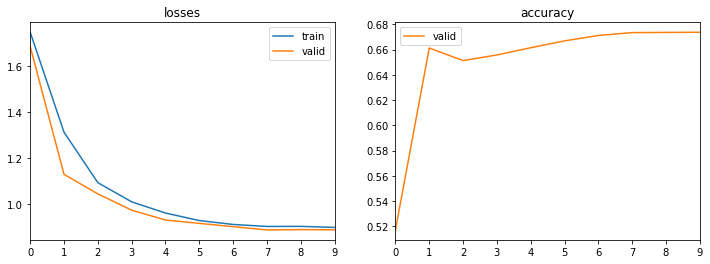

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': True, 'epochs': 50, 'hidden_size': 100, 'lr': 0.0001, 'n_layers': 3, 'optimizer': <function Adam at 0x00000243C597C438>, 'patience': 5, 'time_steps': 90}
GRU                                                                                                                    
 73%|█████████████████████████████████            | 22/30 [1:49:44<34:37, 259.69s/trial, best loss: 0.8221107721328735]

epoch,train_loss,valid_loss,accuracy,time
0,1.811785,1.803417,0.081946,00:11
1,1.762748,1.736858,0.332754,00:11
2,1.649953,1.576398,0.661358,00:12
3,1.348342,1.182547,0.664543,00:12
4,1.121271,1.079664,0.653926,00:12
5,1.057064,1.030830,0.649824,00:12
6,1.017848,0.993247,0.649293,00:12
7,0.961078,0.939042,0.653202,00:12
8,0.924058,0.910436,0.661213,00:12
9,0.904794,0.884552,0.670045,00:12


No improvement since epoch 21: early stopping                                                                          
 73%|█████████████████████████████████            | 22/30 [1:55:30<34:37, 259.69s/trial, best loss: 0.8221107721328735]

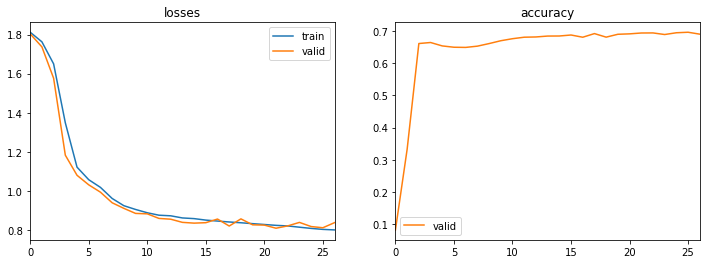

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.0001, 'n_layers': 3, 'optimizer': <function RMSProp at 0x00000243C597C1F8>, 'patience': 5, 'time_steps': 90}
GRU                                                                                                                    
 77%|██████████████████████████████████▌          | 23/30 [1:55:56<34:13, 293.29s/trial, best loss: 0.8221107721328735]

epoch,train_loss,valid_loss,accuracy,time
0,1.794467,1.780726,0.299165,00:04
1,1.751509,1.727788,0.500796,00:05
2,1.674349,1.629495,0.660682,00:05
3,1.521786,1.432774,0.664398,00:05
4,1.275732,1.181615,0.662275,00:05
5,1.127277,1.091594,0.658511,00:05
6,1.071251,1.047303,0.655229,00:05
7,1.036785,0.998053,0.659379,00:05
8,1.000217,0.948529,0.660441,00:05
9,0.952177,0.900171,0.661117,00:05


No improvement since epoch 25: early stopping                                                                          
 77%|██████████████████████████████████▌          | 23/30 [1:58:41<34:13, 293.29s/trial, best loss: 0.8221107721328735]

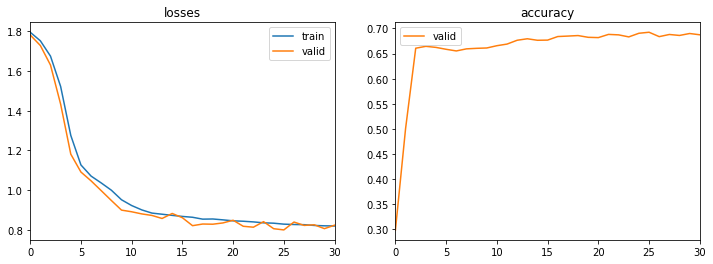

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.0001, 'n_layers': 3, 'optimizer': <function RMSProp at 0x00000243C597C1F8>, 'patience': 5, 'time_steps': 90}
GRU                                                                                                                    
 80%|████████████████████████████████████         | 24/30 [1:59:11<26:16, 262.75s/trial, best loss: 0.8221107721328735]

epoch,train_loss,valid_loss,accuracy,time
0,1.751090,1.747487,0.296993,00:05
1,1.716164,1.703913,0.473288,00:05
2,1.652157,1.620435,0.601515,00:05
3,1.519483,1.445508,0.650065,00:05
4,1.290274,1.195228,0.660586,00:05
5,1.135043,1.098970,0.657352,00:05
6,1.073598,1.054822,0.653926,00:05
7,1.033449,1.014229,0.656629,00:05
8,0.997003,0.961670,0.661117,00:05
9,0.950647,0.906352,0.661792,00:05


No improvement since epoch 24: early stopping                                                                          
 80%|████████████████████████████████████         | 24/30 [2:01:51<26:16, 262.75s/trial, best loss: 0.8221107721328735]

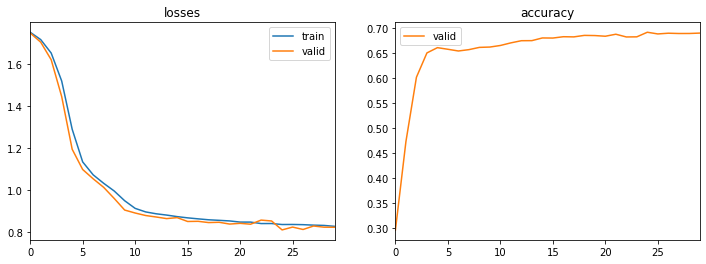

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.0001, 'n_layers': 3, 'optimizer': <function RMSProp at 0x00000243C597C1F8>, 'patience': 5, 'time_steps': 90}
GRU                                                                                                                    
 83%|█████████████████████████████████████▌       | 25/30 [2:02:17<20:04, 240.97s/trial, best loss: 0.8221107721328735]

epoch,train_loss,valid_loss,accuracy,time
0,1.752848,1.739498,0.468028,00:04
1,1.718520,1.697249,0.575262,00:04
2,1.652540,1.613159,0.631002,00:04
3,1.509970,1.427162,0.643984,00:05
4,1.264092,1.171316,0.650451,00:05
5,1.127055,1.085139,0.655760,00:05
6,1.076335,1.044830,0.655905,00:05
7,1.037859,1.009720,0.654939,00:05
8,0.999506,0.955361,0.657835,00:05
9,0.954291,0.911055,0.658655,00:05


No improvement since epoch 42: early stopping                                                                          
 83%|█████████████████████████████████████▌       | 25/30 [2:06:31<20:04, 240.97s/trial, best loss: 0.8221107721328735]

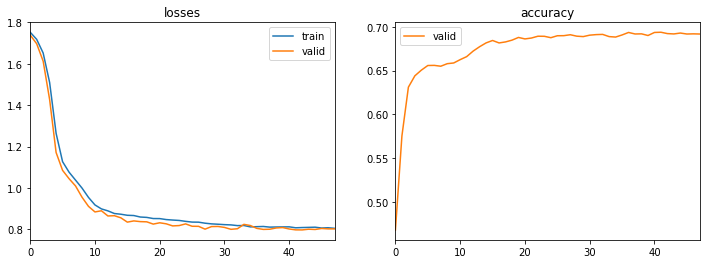

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.0001, 'n_layers': 3, 'optimizer': <function RMSProp at 0x00000243C597C1F8>, 'patience': 5, 'time_steps': 90}
GRU                                                                                                                    
 87%|███████████████████████████████████████      | 26/30 [2:06:57<16:50, 252.62s/trial, best loss: 0.8020673990249634]

epoch,train_loss,valid_loss,accuracy,time
0,1.698704,1.679197,0.636021,00:05
1,1.611772,1.580570,0.660393,00:05
2,1.413397,1.348868,0.664061,00:05
3,1.158440,1.117458,0.661599,00:06
4,1.078633,1.057288,0.652526,00:06
5,1.025214,1.000210,0.654409,00:05
6,0.978413,0.931938,0.658414,00:06
7,0.921765,0.892151,0.667632,00:06
8,0.897678,0.878063,0.667439,00:06
9,0.888636,0.870210,0.673327,00:06


Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.0001, 'n_layers': 3, 'optimizer': <function RMSProp at 0x00000243C597C1F8>, 'patience': 5, 'time_steps': 90}
Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 3, 'optimizer': <function RMSProp at 0x00000243C597C1F8>, 'patience': 5, 'time_steps': 90}
Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.0001, 'n_layers': 3, 'optimizer': <function RMSProp at 0x00000243C597C1F8>, 'patience': 5, 'time_steps': 90}
100%|█████████████████████████████████████████████| 30/30 [2

In [34]:
trials = Trials()
best = fmin(create_model_hypopt,
    space=search_space,
    algo=tpe.suggest,
    max_evals=30,  # test trials
    trials=trials)

In [35]:
print(best)

{'bidirectional': 0, 'bs': 2, 'epochs': 1, 'hidden_size': 0, 'lr': 3, 'n_layers': 2, 'optimizer': 2, 'patience': 0, 'ts': 2}


In [36]:
from hyperopt import space_eval

In [37]:
print("Best parameters:")
print(space_eval(search_space, best))

Best parameters:
{'batch_size': 1024, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.0001, 'n_layers': 3, 'optimizer': <function RMSProp at 0x00000243C597C1F8>, 'patience': 5, 'time_steps': 90}


In [45]:
best_parameters = space_eval(search_space, best)

In [39]:
def build_model(params):
    # clear memory 
    gc.collect()
    print("Trying params:",params)
    batch_size = params["batch_size"]
    time_steps = params["time_steps"]
    
    # Create data loader
    tfms  = [None, [Categorize()]]
    dsets = TSDatasets(X[:, :, -time_steps:], y, tfms=tfms, splits=splits, inplace=True)
    # set num_workers for memory bottleneck
    dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
    # Create model
    arch = GRU
    k = {
        'n_layers': params['n_layers'],
        'hidden_size': params['hidden_size'],
        'bidirectional': params['bidirectional']
    }
    model = create_model(arch, dls=dls, **k)
    print(model.__class__.__name__)
    
    # Training the model
    learn = Learner(dls, model, metrics=accuracy, opt_func=params['optimizer'])
    start = time.time()
    learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                        cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
    learn.plot_metrics()
    elapsed = time.time() - start
    
    # delete tmp variables
    del dls
    del model
    return learn

Trying params: {'batch_size': 1024, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.0001, 'n_layers': 3, 'optimizer': <function RMSProp at 0x000001A51FCCE318>, 'patience': 5, 'time_steps': 90}
GRU


epoch,train_loss,valid_loss,accuracy,time
0,1.805418,1.792700,0.131750,00:05
1,1.755596,1.730118,0.396072,00:04
2,1.664467,1.610017,0.652430,00:04
3,1.479559,1.370168,0.661985,00:04
4,1.228656,1.133483,0.661310,00:04
5,1.107570,1.072591,0.656822,00:04
6,1.066532,1.037691,0.654264,00:05
7,1.034262,0.994628,0.657449,00:04
8,0.988524,0.948527,0.659235,00:05
9,0.939266,0.904356,0.662275,00:04


No improvement since epoch 22: early stopping


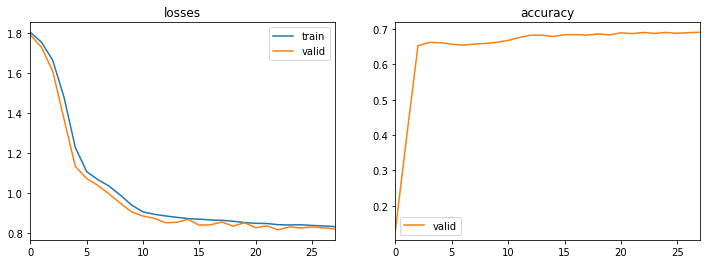

In [40]:
learn = build_model(best_parameters)

In [41]:
dls = learn.dls
valid_dl = dls.valid

In [42]:
time_steps = best_parameters["time_steps"]
X_test_tmp = X_test[:, :, -time_steps:]

In [43]:
test_ds = valid_dl.dataset.add_test(X_test_tmp, y_test)  # use the test data
test_dl = valid_dl.new(test_ds)
print(test_dl.n)

102430


In [44]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
test_probas, test_targets, test_preds

(tensor([[4.4751e-01, 3.3324e-01, 1.4746e-01, 5.8086e-02, 1.2386e-02, 1.3107e-03],
         [8.4468e-01, 1.0937e-01, 3.7645e-02, 7.0500e-03, 1.0486e-03, 1.9817e-04],
         [9.5764e-01, 3.2466e-02, 7.8694e-03, 1.6120e-03, 3.3850e-04, 7.2105e-05],
         ...,
         [9.8279e-01, 1.2364e-02, 3.6044e-03, 1.0384e-03, 1.7298e-04, 3.2115e-05],
         [9.6568e-01, 2.2133e-02, 8.3562e-03, 3.1892e-03, 5.4394e-04, 9.8954e-05],
         [9.4168e-01, 4.7181e-02, 8.8718e-03, 1.9471e-03, 2.6998e-04, 5.0034e-05]]),
 TensorCategory([1, 0, 0,  ..., 0, 0, 0], dtype=torch.int32),
 tensor([0, 0, 0,  ..., 0, 0, 0]))

In [45]:
print(f'accuracy: {skm.accuracy_score(test_targets, test_preds):10.6f}')
print(f'f1 score: {skm.f1_score(test_targets, test_preds, average="weighted"):10.6f}')

accuracy:   0.732666
f1 score:   0.698858


Save the true and predicted results:

In [46]:
y_test_true = test_targets.numpy()
y_test_pred = test_preds.numpy()

In [47]:
np.save('y_true_GRU', y_test_true)
np.save('y_pred_GRU', y_test_pred)